In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import sklearn

In [20]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)

In [21]:
df = pd.read_csv('train.csv')
pd.set_option('display.max_rows', None)

In [22]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=43)

In [23]:
train.shape, test.shape

((1168, 81), (292, 81))

# For this model we gonna modify columns and do more feature selection

In [24]:
X = train.drop(["SalePrice", "Id"], axis=1)
y = train["SalePrice"]
X_test = test.drop(["SalePrice", "Id"], axis=1)
y_test = test["SalePrice"]

In [25]:
cat_cols = [col for col in X.columns if X[col].dtype == 'object']
num_cols = [col for col in X.columns if X[col].dtype != 'object']

<Axes: >

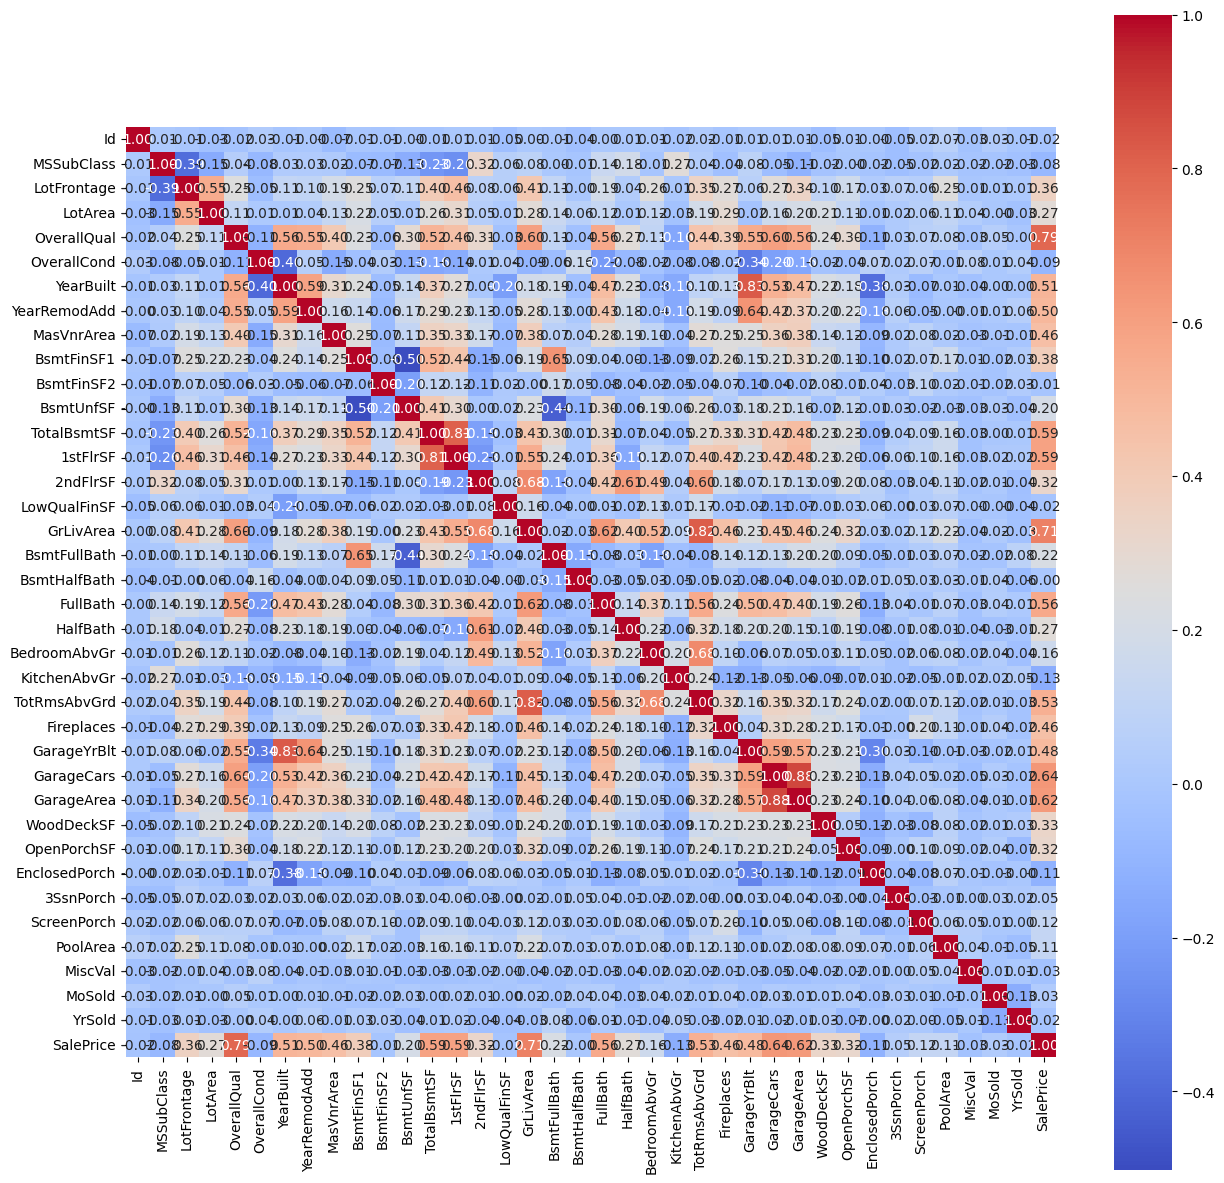

In [26]:
# Compute the correlation matrix for numeric features
corr_matrix = train.corr(numeric_only=True)

# Set up the matplotlib figure
plt.figure(figsize=(15, 20))

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .75})


## CLEANING - Custom Transformer for handling missing values

In [27]:
class DealWithNans(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.fill_values_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X)  # Ensure it's a DataFrame

        for col in X.columns:
            if X[col].dtype == "object" or str(X[col].dtype).startswith("category"):
                # Categorical: use mode
                self.fill_values_[col] = X[col].mode().iloc[0]
            else:
                # Numeric: use median
                self.fill_values_[col] = X[col].median()
        
        return self

    def transform(self, X):
        X = pd.DataFrame(X)  # Ensure it's a DataFrame
        return X.fillna(self.fill_values_)

In [28]:
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.features_to_drop_ = []
        self.constant_cols_ = []

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # Drop constant columns to avoid divide-by-zero in correlation matrix
        self.constant_cols_ = X.columns[X.std() == 0].tolist()
        X_clean = X.drop(columns=self.constant_cols_)

        corr_matrix = X_clean.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones_like(corr_matrix, dtype=bool)))

        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i + 1, len(corr_matrix.columns)):
                if upper.iloc[i, j] > self.threshold:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

        self.features_to_drop_ = []

        for feat1, feat2 in high_corr_pairs:
            # Drop the one with lower correlation to target
            if y is not None:
                corr1 = abs(pd.Series(X[feat1]).corr(pd.Series(y)))
                corr2 = abs(pd.Series(X[feat2]).corr(pd.Series(y)))
                if corr1 < corr2:
                    self.features_to_drop_.append(feat1)
                else:
                    self.features_to_drop_.append(feat2)
            else:
                self.features_to_drop_.append(feat2)

        self.features_to_drop_ = list(set(self.features_to_drop_ + self.constant_cols_))
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        return X.drop(columns=self.features_to_drop_, errors='ignore')


# FEATURE ENGINEERING - Categorical encoding

In [29]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
pipeline = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        ('num', 'passthrough', num_cols)
    ])),
    ("nan_filler", DealWithNans()),
    # Step 2: Correlation Filter
    ('correlation_filter', CorrelationFilter(threshold=0.9)),
    
    # Step 3: Feature Scaling
    ('scaler', StandardScaler()),
    
    # Step 4: RFE
    ('rfe', RFE(
        estimator=LinearRegression(),
        n_features_to_select=40,
        step=5
    )),
    ("model", LinearRegression())
]) 

# TRAINING - GridSearch with cross-validation

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# Define parameter grid for hyperparameter tuning
param_grid = {
    "model__fit_intercept": [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="r2", verbose=2)
grid_search.fit(X, y)

# Best parameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)
# Get the best model
best_model = grid_search.best_estimator_

# Evaluate on the test set using the best model
predictions_test = best_model.predict(X_test)

# Calculate test metrics
r2_test = r2_score(test["SalePrice"], predictions_test)
rmse_test = np.sqrt(mean_squared_error(test["SalePrice"], predictions_test))
mae_test = mean_absolute_error(test["SalePrice"], predictions_test)

# Output test metrics

print("\nTest Set Evaluation:")
print(grid_search.best_score_)

print("Test R² Score:", r2_test)
print("Test RMSE:", rmse_test)
print("Test MAE:", mae_test)


Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[CV] END ..........................model__fit_intercept=True; total time=   1.2s


/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[CV] END ..........................model__fit_intercept=True; total time=   1.2s


/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[CV] END ..........................model__fit_intercept=True; total time=   1.2s


/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[CV] END ..........................model__fit_intercept=True; total time=   1.2s


/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[CV] END ..........................model__fit_intercept=True; total time=   1.3s


/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[CV] END .........................model__fit_intercept=False; total time=   1.2s


/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[CV] END .........................model__fit_intercept=False; total time=   1.2s


/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[CV] END .........................model__fit_intercept=False; total time=   1.2s


/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[CV] END .........................model__fit_intercept=False; total time=   1.3s


/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[CV] END .........................model__fit_intercept=False; total time=   1.3s


/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/temo/machine_learning/complete-pandas-tutorial/tutorial/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Best Hyperparameters: {'model__fit_intercept': True}

Test Set Evaluation:
-1294463788.4481895
Test R² Score: 0.8070409415716477
Test RMSE: 1228384922.4739742
Test MAE: 17820.323930696937


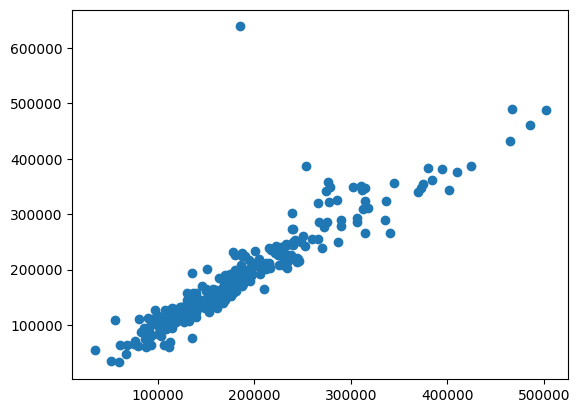

In [13]:
plt.scatter(test["SalePrice"], predictions_test)

<Axes: xlabel='SalePrice', ylabel='Count'>

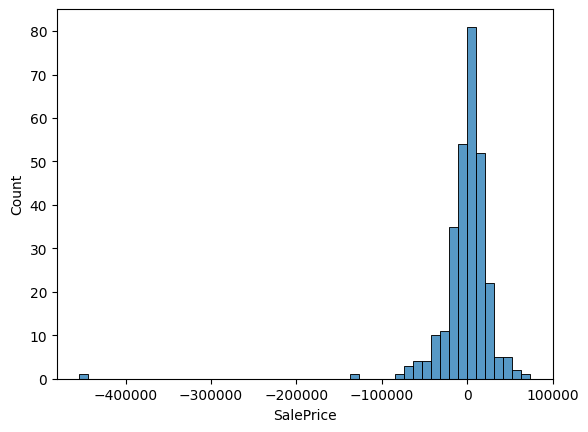

In [14]:
sns.histplot((test["SalePrice"] - predictions_test),bins=50)

In [15]:
import dagshub
import mlflow   
dagshub.init(repo_owner='mr-master-afk', repo_name='ML-House-price-prediction', mlflow=True)

Accessing as mr-master-afk

Initialized MLflow to track repo "mr-master-afk/ML-House-price-prediction"

Repository mr-master-afk/ML-House-price-prediction initialized!

MLflow run logged.
🏃 View run HousePrice_LinearRFE at: https://dagshub.com/mr-master-afk/ML-House-price-prediction.mlflow/#/experiments/0/runs/0c34ac3049594703abe55e1e5649241f
🧪 View experiment at: https://dagshub.com/mr-master-afk/ML-House-price-prediction.mlflow/#/experiments/0


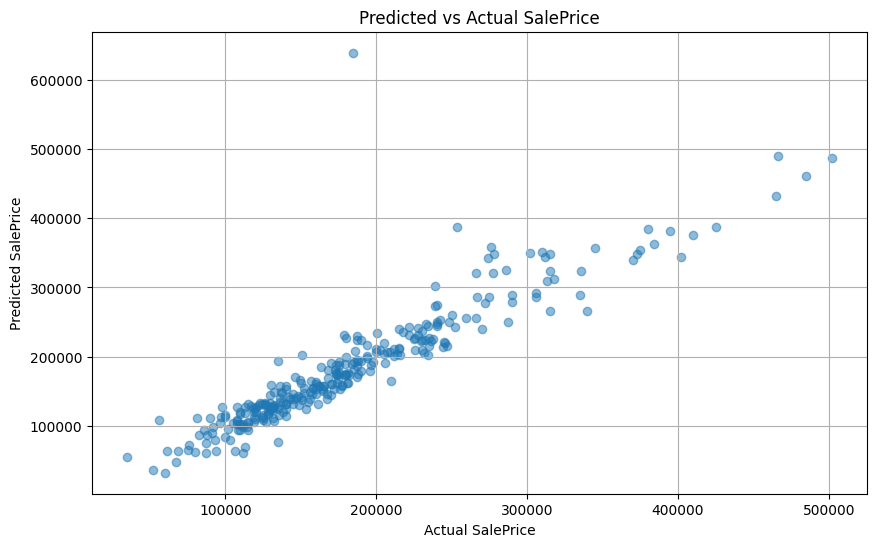

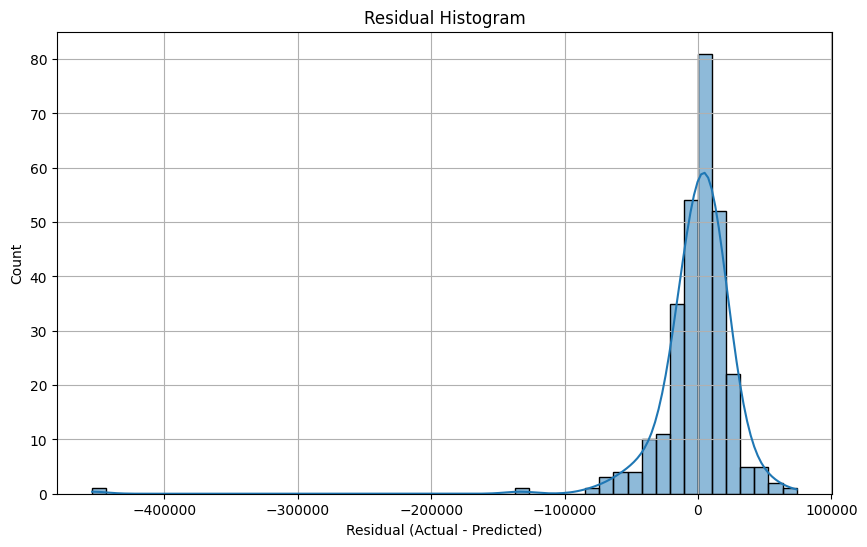

In [16]:
with mlflow.start_run(run_name="HousePrice_LinearRFE"):

    # Log parameters
    mlflow.log_param("fit_intercept", grid_search.best_params_["model__fit_intercept"])
    mlflow.log_param("rfe_n_features", 40)
    mlflow.log_param("rfe_step", 5)
    mlflow.log_param("correlation_threshold", 0.9)

    # Log metrics
    mlflow.log_metric("cv_r2_score", grid_search.best_score_)
    mlflow.log_metric("test_r2", r2_test)
    mlflow.log_metric("test_rmse", rmse_test)
    mlflow.log_metric("test_mae", mae_test)

    # Scatter Plot: Predictions vs Actuals
    plt.figure(figsize=(10, 6))
    plt.scatter(test["SalePrice"], predictions_test, alpha=0.5)
    plt.xlabel("Actual SalePrice")
    plt.ylabel("Predicted SalePrice")
    plt.title("Predicted vs Actual SalePrice")
    plt.grid(True)
    scatter_path = "pred_vs_actual.png"
    plt.savefig(scatter_path)
    mlflow.log_artifact(scatter_path)

    # Histogram of Residuals
    plt.figure(figsize=(10, 6))
    sns.histplot((test["SalePrice"] - predictions_test), bins=50, kde=True)
    plt.xlabel("Residual (Actual - Predicted)")
    plt.title("Residual Histogram")
    plt.grid(True)
    hist_path = "residual_hist.png"
    plt.savefig(hist_path)
    mlflow.log_artifact(hist_path)

    print("MLflow run logged.")